# Dataset Creation


Since datasets consisting of multiple invoices were not readily available online, I created a custom dataset. To achieve this, images from existing invoice datasets for object detection werre utilised and randomly combined individual images to form the new dataset.



Connect google drive to access data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary libraries

In [ ]:
import os
import cv2
import numpy as np

# Key point annotations to bounding box annotations

Since there were not enough images for training from just one dataset, I used two datasets to gather sufficient images. One of these datasets included key point annotations.

Function to convert Keypoint annotations to yolo bounding box annotations.

In [ ]:
def convert_keypoints_to_yolo(annotation, img_width, img_height):
    class_id = annotation[0]
    keypoints = annotation[1:]

    # Parsing the list of coordinates
    points = []
    for i in range(0, len(keypoints), 2):
        x_rel = float(keypoints[i])
        y_rel = float(keypoints[i + 1])

        # Converting to absolute coordinates
        x = int(x_rel * img_width)
        y = int(y_rel * img_height)

        points.append((x, y))

    # Finding the minimum and maximum values for x and y coordinates
    x_coords = [point[0] for point in points]
    y_coords = [point[1] for point in points]

    x_min = min(x_coords)
    x_max = max(x_coords)
    y_min = min(y_coords)
    y_max = max(y_coords)

    # Calculating center, width, and height
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    # Normalizing
    center_x /= img_width
    center_y /= img_height
    width /= img_width
    height /= img_height

    # Formating for YOLO annotaition
    yolo_annotation = [class_id, center_x, center_y, width, height]
    return yolo_annotation


Function to open and iterate through dataset to convert to bounding box annotations

In [ ]:
def process_annotations_folder(annotations_folder_path, images_folder_path):
  #iterating through each file in annotations folder
    for filename in os.listdir(annotations_folder_path):
        if filename.endswith(".txt"):  # checking for txt files
            annotation_path = os.path.join(annotations_folder_path, filename)
            #reading annotation file
            with open(annotation_path, 'r') as file:
                lines = file.readlines()

            #getting path of image file
            image_filename = filename.replace('.txt', '.jpg')  # Assuming image files are in JPG format
            image_path = os.path.join(images_folder_path, image_filename)
            image = cv2.imread(image_path)
            #getting dimensions of image file
            img_height, img_width, _ = image.shape

            #converting each line of annotations
            yolo_annotations = []
            for line in lines:
                annotation = list(map(float, line.strip().split()))
                yolo_annotation = convert_keypoints_to_yolo(annotation, img_width, img_height)
                yolo_annotations.append(yolo_annotation)

            # Save the converted annotations back to the file
            with open(annotation_path, 'w') as file:
                for yolo_annotation in yolo_annotations:
                    file.write(' '.join(map(str, yolo_annotation)) + '\n')

Converting annotation for train, test and validation folders

In [ ]:
# Converting train folder
annotations_folder_path = '/content/drive/MyDrive/Receipt dataset_2/train/labels'
images_folder_path = '/content/drive/MyDrive/Receipt dataset_2/train/images'

# Process the folder of annotations
process_annotations_folder(annotations_folder_path, images_folder_path)

In [ ]:
# Converting test folder
annotations_folder_path = '/content/drive/MyDrive/Receipt dataset_2/test/labels'
images_folder_path = '/content/drive/MyDrive/Receipt dataset_2/test/images'

# Process the folder of annotations
process_annotations_folder(annotations_folder_path, images_folder_path)

In [ ]:
# Converting valid folder
annotations_folder_path = '/content/drive/MyDrive/Receipt dataset_2/valid/labels'
images_folder_path = '/content/drive/MyDrive/Receipt dataset_2/valid/images'

# Process the folder of annotations
process_annotations_folder(annotations_folder_path, images_folder_path)

# Removing redundant annotations

A function to remove unnecessary annotations from a dataset folder

In [ ]:
import os

def process_annotation_file(file_path):
    # Read the content of the annotation file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Process each line and keep only class 4, changing it to class 0
    processed_lines = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        if class_id == 4:
            parts[0] = '0'
            processed_lines.append(' '.join(parts) + '\n')

    # Write the processed lines back to the file
    with open(file_path, 'w') as file:
        file.writelines(processed_lines)

def process_annotations_directory(directory_path):
    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)

        # Process only if it's a file
        if os.path.isfile(file_path):
            process_annotation_file(file_path)


Call the function for each folder

In [ ]:
# Specify the directory containing the annotation files
annotations_directory = '/content/drive/MyDrive/Receipts_Dataset/train/labels'

# Process the annotations directory
process_annotations_directory(annotations_directory)

In [ ]:
# Specify the directory containing the annotation files
annotations_directory = '/content/drive/MyDrive/Receipts_Dataset/test/labels'

# Process the annotations directory
process_annotations_directory(annotations_directory)

In [ ]:
# Specify the directory containing the annotation files
annotations_directory = '/content/drive/MyDrive/Receipts_Dataset/valid/labels'

# Process the annotations directory
process_annotations_directory(annotations_directory)

#Skipping multiple invoice images


A function to check for images which already have multiple invoices by cchecking the annotation files for multiple annotations

In [ ]:
import os
import shutil

# Define the paths to the folders
annotations_folder = '/content/drive/MyDrive/Receipt dataset_2/train/labels'
images_folder = '/content/drive/MyDrive/Receipt dataset_2/train/images'
destination_annotations_folder = '/content/drive/MyDrive/Combined Dataset2/train/labels'
destination_images_folder = '/content/drive/MyDrive/Combined Dataset2/train/images'

# Ensure the destination folders exist
os.makedirs(destination_annotations_folder, exist_ok=True)
os.makedirs(destination_images_folder, exist_ok=True)

# Iterate through the annotation files
for annotation_file in os.listdir(annotations_folder):
    if annotation_file.endswith('.txt'):
        annotation_file_path = os.path.join(annotations_folder, annotation_file)

        # Read the contents of the annotation file
        with open(annotation_file_path, 'r') as file:
            lines = file.readlines()

        # Check if the file contains multiple detection annotations
        if len(lines) > 1:
            # Move the annotation file
            shutil.move(annotation_file_path, os.path.join(destination_annotations_folder, annotation_file))

            # Construct the corresponding image file name
            image_file_name = os.path.splitext(annotation_file)[0] + '.jpg'  # Assuming the image format is .jpg
            image_file_path = os.path.join(images_folder, image_file_name)

            if os.path.exists(image_file_path):
                # Move the image file
                shutil.move(image_file_path, os.path.join(destination_images_folder, image_file_name))
            else:
                print(f"Image file {image_file_name} does not exist. Skipping.")


# Random 1 to 6 image concatenation

This function takes a list of images and arranges them into a grid with two columns. The number of rows is determined based on the number of images. The function first calculates the grid dimensions by finding the maximum width and height of the images. It then creates a blank canvas of the appropriate size and places each image onto this canvas in its correct position within the grid. The function returns the final concatenated grid image along with the maximum width and height of the images.

In [ ]:
#grid
import os
import random
import cv2
import numpy as np

def concatenate_images_grid(images):
    """
    Concatenate images in a grid-like pattern.
    The images list contains images to be concatenated.
    """
    num_images = len(images)
    if num_images == 0:
        return None

    # Calculate grid size
    rows = (num_images + 1) // 2  # Number of rows
    cols = 2  # Number of columns (always 2)

    # Determine the maximum width and height of images
    max_width = max(img.shape[1] for img in images)
    max_height = max(img.shape[0] for img in images)

    # Create a blank canvas with the calculated grid size
    grid_height = rows * max_height
    grid_width = cols * max_width
    grid_image = np.zeros((grid_height, grid_width, 3), dtype=np.uint8)

    # Paste images into the grid
    for idx, img in enumerate(images):
        row = idx // 2
        col = idx % 2
        start_y = row * max_height
        start_x = col * max_width
        grid_image[start_y:start_y + img.shape[0], start_x:start_x + img.shape[1]] = img

    return grid_image, max_width, max_height


This function updates a list of image annotations to correspond to a grid layout of images. Each annotation includes a class label and bounding box coordinates (x, y, width, height) in normalized form. The function adjusts these annotations to fit into a new grid where the images are arranged in two columns. It first calculates the pixel coordinates for each annotation based on the original image dimensions and then adjusts these coordinates to account for the position of each image in the grid. Finally, the coordinates are re-normalized based on the dimensions of the entire grid. The function returns the updated list of annotations, reflecting their new positions in the grid.

In [ ]:

def update_annotations_grid(annotations, widths, heights, max_width, max_height):
    updated_annotations = []

    for i, annotation_list in enumerate(annotations):
        row = i // 2
        col = i % 2

        offset_x = col * max_width
        offset_y = row * max_height

        for annotation in annotation_list:
            class_label = annotation[0]
            x, y, w, h = annotation[1:]

            # Convert normalized coordinates to pixel values
            x_pixel = x * widths[i]
            y_pixel = y * heights[i]
            w_pixel = w * widths[i]
            h_pixel = h * heights[i]

            # Adjust coordinates with the current offsets
            updated_x_pixel = x_pixel + offset_x
            updated_y_pixel = y_pixel + offset_y

            # Convert back to normalized coordinates based on the grid size
            grid_width = 2 * max_width
            grid_height = ((len(annotations) + 1) // 2) * max_height

            updated_x = updated_x_pixel / grid_width
            updated_y = updated_y_pixel / grid_height
            updated_w = w_pixel / grid_width
            updated_h = h_pixel / grid_height

            updated_annotation = [class_label, updated_x, updated_y, updated_w, updated_h]
            updated_annotations.append(updated_annotation)

    return updated_annotations

Define path for train, test and validation folders seperately

In [ ]:
# Paths
existing_dataset_path = "/content/drive/MyDrive/Receipts_Dataset/train/images"
new_dataset_path_images = "/content/drive/MyDrive/Combined Dataset2/train/images"
new_dataset_path_labels = "/content/drive/MyDrive/Combined Dataset2/train/labels"
annotations_folder_path = "/content/drive/MyDrive/Receipts_Dataset/train/labels"


In [ ]:
# Paths
existing_dataset_path = "/content/drive/MyDrive/Receipts_Dataset/test/images"
new_dataset_path_images = "/content/drive/MyDrive/Combined Dataset2/test/images"
new_dataset_path_labels = "/content/drive/MyDrive/Combined Dataset2/test/labels"
annotations_folder_path = "/content/drive/MyDrive/Receipts_Dataset/test/labels"


In [ ]:
# Paths
existing_dataset_path = "/content/drive/MyDrive/Receipts_Dataset/valid/images"
new_dataset_path_images = "/content/drive/MyDrive/Combined Dataset2/valid/images"
new_dataset_path_labels = "/content/drive/MyDrive/Combined Dataset2/valid/labels"
annotations_folder_path = "/content/drive/MyDrive/Receipts_Dataset/valid/labels"


This code processes an existing dataset of images and their annotations by randomly selecting between 1 and 6 images at a time, concatenating them into a grid, and adjusting the associated annotations accordingly. It iterates through the dataset, loading images and their corresponding annotation files, and then combines the selected images into a grid layout. The annotations are updated to reflect the new positions of the images within the grid. The newly created grid image and its updated annotations are then saved to specified directories. The process repeats until all images are processed or there are not enough images left for another concatenation.

In [ ]:

# Iterate through existing dataset
items = [item for item in os.listdir(existing_dataset_path) if item.endswith(".jpg")]
num_items = len(items)

index = 0
while index < num_items:
    # Randomly select the number of images to concatenate (between 1 and 6)
    num_images_to_concatenate = random.randint(1, 6)
    selected_images = items[index:index + num_images_to_concatenate]
    if len(selected_images) < num_images_to_concatenate:
        break  # Exit if not enough images left to concatenate

    images = []
    annotations = []
    widths = []
    heights = []

    for image_name in selected_images:
        # Load images
        img = cv2.imread(os.path.join(existing_dataset_path, image_name))
        images.append(img)
        widths.append(img.shape[1])
        heights.append(img.shape[0])

        # Load annotations
        annotation_file = os.path.join(annotations_folder_path, image_name.split(".jpg")[0] + ".txt")
        with open(annotation_file, "r") as f:
            annotation_data = f.readlines()
            annotations.append([list(map(float, annotation.strip().split())) for annotation in annotation_data])

    # Concatenate images in grid
    new_image, max_width, max_height = concatenate_images_grid(images)

    # Update annotations for the grid
    updated_annotations = update_annotations_grid(annotations, widths, heights, max_width, max_height)

    # Save new image
    new_image_name = f"combined_{index}.jpg"
    cv2.imwrite(os.path.join(new_dataset_path_images, new_image_name), new_image)

    # Save updated annotations
    new_annotation_file = os.path.join(new_dataset_path_labels, f"combined_{index}.txt")
    with open(new_annotation_file, "w") as f:
        for annotation in updated_annotations:
            f.write(' '.join(map(str, annotation)) + '\n')

    # Update index to skip concatenated images in the next iteration
    index += num_images_to_concatenate



---

# Experimentation codes


Concatenate 2 images

In [ ]:
# Function to horizontally concatenate two images
def concatenate_images(img1, img2):
    return np.concatenate((img1, img2), axis=1)

In [ ]:
#2 image updation
def update_annotations(annotations1,annotations2, width1,width2):
    updated_annotations1 = []
    updated_annotations2 = []

    for annotation in annotations1:
        class_label = annotation[0]
        x, y, w, h = annotation[1:]

        # Update bounding box coordinates for the second image
        x_pixel=x*width1
        updated_x=x_pixel/(width1+width2)

        w_pixel=w*width1
        updated_w=w_pixel/(width1+width2)
        updated_annotation = [class_label, updated_x, y, updated_w, h]
        updated_annotations1.append(updated_annotation)

    for annotation in annotations2:
        class_label = annotation[0]
        x, y, w, h = annotation[1:]

        # Update bounding box coordinates for the second image
        x_pixel=x*width2
        x_pixel_offset=x_pixel+width1
        updated_x=x_pixel_offset/(width1+width2)

        w_pixel=w*width2
        updated_w=w_pixel/(width1+width2)
        updated_annotation = [class_label, updated_x, y, updated_w, h]
        updated_annotations2.append(updated_annotation)

    return updated_annotations1,updated_annotations2


In [ ]:
# Path to existing dataset
existing_dataset_path = "/content/drive/MyDrive/Receipts_Dataset/test/images"

# Path to save the new dataset
new_dataset_path = "/content/drive/MyDrive/Combined Dataset"
annotations_folder_path="/content/drive/MyDrive/Receipts_Dataset/test/labels"

In [ ]:
# Iterate through existing dataset
items = os.listdir(existing_dataset_path)

for index, image_name in enumerate(items):
    if image_name.endswith(".jpg"):  # Assuming images are in JPG format

        if index + 1 < len(items):
          # Load images
          img1 = cv2.imread(os.path.join(existing_dataset_path, image_name))
          next_item_name = items[index + 1]
          img2 = cv2.imread(os.path.join(existing_dataset_path, next_item_name))

          # Concatenate images
          new_image = concatenate_images(img1, img2)

          # Load annotations
          annotation_file1 = os.path.join(annotations_folder_path, image_name.split(".jpg")[0] + ".txt")
          annotation_file2 = os.path.join(annotations_folder_path, next_item_name.split(".jpg")[0] + ".txt")
          with open(annotation_file1, "r") as f1,open(annotation_file2, "r") as f2:
              annotations1 = f1.readlines()
              annotations1 = [list(map(float, annotation.strip().split())) for annotation in annotations1]

              annotations2 = f2.readlines()
              annotations2 = [list(map(float, annotation.strip().split())) for annotation in annotations2]

          # Update annotations for img2
          updated_annotations1,updated_annotations2 = update_annotations(annotations1,annotations2, img1.shape[1],img2.shape[1])

          # Save new image
          cv2.imwrite(os.path.join(new_dataset_path, image_name), new_image)

          # Save updated annotations
          new_annotation_file = os.path.join(new_dataset_path, image_name.split(".jpg")[0] + ".txt")
          with open(new_annotation_file, "w") as f:
              # Write annotations for img1
              for annotation in updated_annotations1:
                  f.write(' '.join(map(str, annotation)) + '\n')

              # Write annotations for img2
              for annotation in updated_annotations2:
                  f.write(' '.join(map(str, annotation)) + '\n')

Random horizontal concatenation

In [ ]:
#random 1 to 6 horizontal concatenation
import os
import random
import cv2
import numpy as np

# Function to horizontally concatenate multiple images
def concatenate_images(images):
    return np.concatenate(images, axis=1)

def update_annotations(annotations, widths):
    updated_annotations = []
    total_width = sum(widths)
    current_offset = 0

    for i, (annotation_list, width) in enumerate(zip(annotations, widths)):
        for annotation in annotation_list:
            class_label = annotation[0]
            x, y, w, h = annotation[1:]

            # Convert normalized coordinates to pixel values
            x_pixel = x * width
            w_pixel = w * width

            # Adjust the x-coordinate for the current offset
            updated_x_pixel = x_pixel + current_offset
            updated_x = updated_x_pixel / total_width
            updated_w = w_pixel / total_width

            updated_annotation = [class_label, updated_x, y, updated_w, h]
            updated_annotations.append(updated_annotation)

        # Update the offset for the next image
        current_offset += width

    return updated_annotations

# Paths
existing_dataset_path = "/content/drive/MyDrive/Receipts_Dataset/test/images"
new_dataset_path = "/content/drive/MyDrive/Combined Dataset"
annotations_folder_path = "/content/drive/MyDrive/Receipts_Dataset/test/labels"

# Iterate through existing dataset
items = [item for item in os.listdir(existing_dataset_path) if item.endswith(".jpg")]
num_items = len(items)

for index in range(num_items):
    if index + 1 < num_items:
        # Randomly select the number of images to concatenate (between 1 and 6)
        num_images_to_concatenate = random.randint(1, 6)
        selected_images = items[index:index + num_images_to_concatenate]
        if len(selected_images) < num_images_to_concatenate:
            continue  # Skip if not enough images left to concatenate

        images = []
        annotations = []
        widths = []

        for image_name in selected_images:
            # Load images
            img = cv2.imread(os.path.join(existing_dataset_path, image_name))
            images.append(img)
            widths.append(img.shape[1])

            # Load annotations
            annotation_file = os.path.join(annotations_folder_path, image_name.split(".jpg")[0] + ".txt")
            with open(annotation_file, "r") as f:
                annotation_data = f.readlines()
                annotations.append([list(map(float, annotation.strip().split())) for annotation in annotation_data])

        # Concatenate images
        new_image = concatenate_images(images)

        # Update annotations
        updated_annotations = update_annotations(annotations, widths)

        # Save new image
        new_image_name = f"combined_{index}.jpg"
        cv2.imwrite(os.path.join(new_dataset_path, new_image_name), new_image)

        # Save updated annotations
        new_annotation_file = os.path.join(new_dataset_path, f"combined_{index}.txt")
        with open(new_annotation_file, "w") as f:
            for annotation in updated_annotations:
                f.write(' '.join(map(str, annotation)) + '\n')

        # Update index to skip concatenated images in the next iteration
        index += num_images_to_concatenate - 1


Code to display annotations on image

In [ ]:
#displaying the concatenated image
import cv2
import numpy as np

# Load the image
image_path = '/content/drive/MyDrive/Combined Dataset/valid/images/combined_92.jpg'
image = cv2.imread(image_path)

# Define class names
class_names = ['Item list', 'Merchant name', 'address', 'date', 'invoice',
               'payment information', 'price', 'sum', 'tax information']

# Load annotations from the text file
annotations_path = '/content/drive/MyDrive/Combined Dataset/valid/labels/combined_92.txt'
    annotations = [line.strip().split() for line in f]

# Draw bounding boxes and labels
for ann in annotations:
    class_id, x_center, y_center, width, height = map(float, ann)
    x_min = int((x_center - width / 2) * image.shape[1])
    y_min = int((y_center - height / 2) * image.shape[0])
    x_max = int((x_center + width / 2) * image.shape[1])
    y_max = int((y_center + height / 2) * image.shape[0])
    class_name = class_names[int(class_id)]

    # Draw bounding box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # Add label
    cv2.putText(image, class_name, (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Save the annotated image
annotated_image_path = 'annotated_image.jpg'  # Specify the desired output path
cv2.imwrite(annotated_image_path, image)


True

Code to check image dimentations

In [ ]:
import cv2

# Read the image
image = cv2.imread('/content/drive/MyDrive/Receipt dataset_2/test/images/1000-receipt_jpg.rf.7c7c7e39a0ae347857a8d2f9f2f544ca.jpg')

# Get the dimensions of the image
height, width, channels = image.shape

print(f"Image dimensions: Height = {height}, Width = {width}, Channels = {channels}")


Image dimensions: Height = 416, Width = 416, Channels = 3


Testing code for keypoint to yolo conversion

In [ ]:
import numpy as np

# Keypoint annotation format (example)
keypoint_annotation = [0, 0.5240384615384616, 0.9915865384615384, 0.9158653846153846, 0.9699519230769231, 0.8774038461538461, 0.20793269230769232, 0.8641826923076923, 0.15625, 0.22956730769230768, 0.20192307692307693, 0.21875, 0.2127403846153846, 0.19471153846153846, 0.3425480769230769, 0.11778846153846154, 0.9699519230769231, 0.13822115384615385, 0.9783653846153846, 0.390625, 0.9927884615384616, 0.5240384615384616, 0.9915865384615384]

image_path='/content/drive/MyDrive/Receipt dataset_2/test/images/1000-receipt_jpg.rf.7c7c7e39a0ae347857a8d2f9f2f544ca.jpg'
# Extract class label and keypoints
class_id = keypoint_annotation[0]
image = cv2.imread(image_path)
img_height, img_width, _ = image.shape

# Parse the list of coordinates
points = []
for i in range(0, len(keypoint_annotation[1:]), 2):
    x_rel = float(annotations[i])
    y_rel = float(annotations[i + 1])

    # Convert to absolute coordinates
    x = int(x_rel * img_width)
    y = int(y_rel * img_height)

    points.append((x, y))

# Find the minimum and maximum values for x and y coordinates
x_coords = [point[0] for point in points]
y_coords = [point[1] for point in points]

x_min = min(x_coords)
x_max = max(x_coords)
y_min = min(y_coords)
y_max = max(y_coords)

#keypoints = np.array(keypoint_annotation[1:]).reshape(-1, 2)

# Calculate bounding box
#x_min = np.min(keypoints[:, 0])
#y_min = np.min(keypoints[:, 1])
#x_max = np.max(keypoints[:, 0])
#y_max = np.max(keypoints[:, 1])

# Calculate center, width, and height
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2
width = x_max - x_min
height = y_max - y_min

# Normalize if necessary (assuming normalization to [0, 1] range)
center_x /= img_width
center_y /= img_height
width /= img_width
height /= img_height

# Format for YOLO
yolo_annotation = [class_id, center_x, center_y, width, height]

print(yolo_annotation)


[0, 0.5168269230769231, 0.5745192307692307, 0.7980769230769231, 0.8365384615384616]


Displaying keypoints on an image

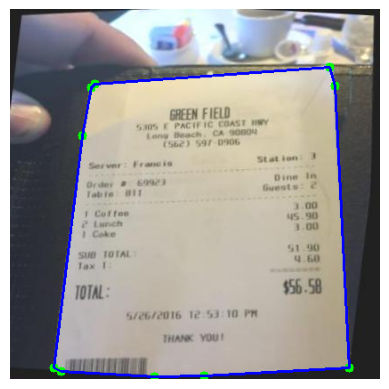

In [ ]:
import cv2
import matplotlib.pyplot as plt

def plot_points_on_image(image_path, annotations):
    # Read the image
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape

    # Parse the list of coordinates
    points = []
    for i in range(0, len(annotations), 2):
        x_rel = float(annotations[i])
        y_rel = float(annotations[i + 1])

        # Convert to absolute coordinates
        x = int(x_rel * img_width)
        y = int(y_rel * img_height)

        points.append((x, y))

        # Draw the point on the image
        cv2.circle(image, (x, y), radius=5, color=(0, 255, 0), thickness=-1)

    # Optionally, draw lines connecting the points
    for i in range(len(points) - 1):
        cv2.line(image, points[i], points[i + 1], color=(255, 0, 0), thickness=2)

    # Convert BGR image (used by OpenCV) to RGB (used by Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with points
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/Receipt dataset_2/test/images/1000-receipt_jpg.rf.7c7c7e39a0ae347857a8d2f9f2f544ca.jpg'
annotations = [
    0.5240384615384616, 0.9915865384615384,
    0.9158653846153846, 0.9699519230769231,
    0.8774038461538461, 0.20793269230769232,
    0.8641826923076923, 0.15625,
    0.22956730769230768, 0.20192307692307693,
    0.21875, 0.2127403846153846,
    0.19471153846153846, 0.3425480769230769,
    0.11778846153846154, 0.9699519230769231,
    0.13822115384615385, 0.9783653846153846,
    0.390625, 0.9927884615384616,
    0.5240384615384616, 0.9915865384615384
]
plot_points_on_image(image_path, annotations)


Displaying keypoint to bounding box conversion

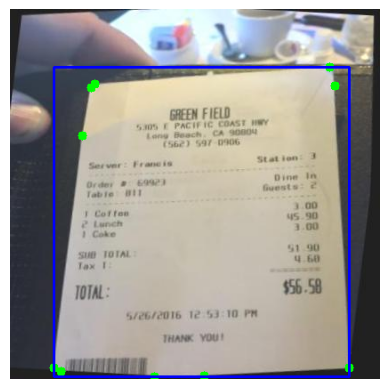

x_min: 49, x_max: 381, y_min: 65, y_max: 413


In [ ]:
import cv2
import matplotlib.pyplot as plt

def plot_points_and_bounding_box(image_path, annotations):
    # Read the image
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape

    # Parse the list of coordinates
    points = []
    for i in range(0, len(annotations), 2):
        x_rel = float(annotations[i])
        y_rel = float(annotations[i + 1])

        # Convert to absolute coordinates
        x = int(x_rel * img_width)
        y = int(y_rel * img_height)

        points.append((x, y))

    # Find the minimum and maximum values for x and y coordinates
    x_coords = [point[0] for point in points]
    y_coords = [point[1] for point in points]

    x_min = min(x_coords)
    x_max = max(x_coords)
    y_min = min(y_coords)
    y_max = max(y_coords)

    # Draw the points on the image
    for (x, y) in points:
        cv2.circle(image, (x, y), radius=5, color=(0, 255, 0), thickness=-1)

    # Draw the bounding box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    # Convert BGR image (used by OpenCV) to RGB (used by Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with points and bounding box
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

    # Print bounding box coordinates
    print(f"x_min: {x_min}, x_max: {x_max}, y_min: {y_min}, y_max: {y_max}")

# Example usage
image_path = '/content/drive/MyDrive/Receipt dataset_2/test/images/1000-receipt_jpg.rf.7c7c7e39a0ae347857a8d2f9f2f544ca.jpg'
annotations = [
    0.5240384615384616, 0.9915865384615384,
    0.9158653846153846, 0.9699519230769231,
    0.8774038461538461, 0.20793269230769232,
    0.8641826923076923, 0.15625,
    0.22956730769230768, 0.20192307692307693,
    0.21875, 0.2127403846153846,
    0.19471153846153846, 0.3425480769230769,
    0.11778846153846154, 0.9699519230769231,
    0.13822115384615385, 0.9783653846153846,
    0.390625, 0.9927884615384616,
    0.5240384615384616, 0.9915865384615384
]
plot_points_and_bounding_box(image_path, annotations)


Display yolo annotated image

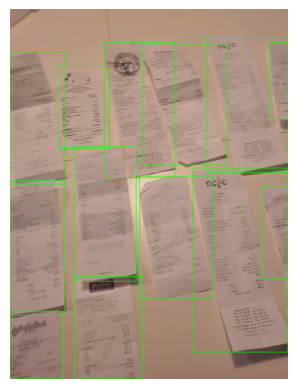

In [ ]:
import cv2
import matplotlib.pyplot as plt

def plot_bounding_boxes(image_path, annotation_path):
    # Read the image
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape

    # Read the YOLO annotation file
    with open(annotation_path, 'r') as file:
        annotations = file.readlines()

    # Parse each line in the annotation file
    for annotation in annotations:
        parts = annotation.strip().split()
        class_id = int(float(parts[0]))
        x_center_rel = float(parts[1])
        y_center_rel = float(parts[2])
        width_rel = float(parts[3])
        height_rel = float(parts[4])

        # Convert to absolute coordinates
        x_center = x_center_rel * img_width
        y_center = y_center_rel * img_height
        bbox_width = width_rel * img_width
        bbox_height = height_rel * img_height

        x_min = int(x_center - bbox_width / 2)
        y_min = int(y_center - bbox_height / 2)
        x_max = int(x_center + bbox_width / 2)
        y_max = int(y_center + bbox_height / 2)

        # Draw the bounding box on the image
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # Convert BGR image (used by OpenCV) to RGB (used by Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/Combined Dataset2/train/images/20230617_141947-mp4-t-8_jpg.rf.e85bbe31edc0b67cb179832b102f3cbd.jpg'
annotation_path = '/content/drive/MyDrive/Combined Dataset2/train/labels/20230617_141947-mp4-t-8_jpg.rf.e85bbe31edc0b67cb179832b102f3cbd.txt'
plot_bounding_boxes(image_path, annotation_path)


Function to move images to another folder

In [ ]:
import os
import shutil

def move_all_items(src_folder, dest_folder):
    # Ensure the destination folder exists
    os.makedirs(dest_folder, exist_ok=True)

    # Iterate through all items in the source folder
    for item_name in os.listdir(src_folder):
        # Construct full file paths
        src_item_path = os.path.join(src_folder, item_name)
        dest_item_path = os.path.join(dest_folder, item_name)

        # Move the item
        shutil.move(src_item_path, dest_item_path)

# Example usage
dest_folder = '/content/drive/MyDrive/Receipts_Dataset/train/labels'
src_folder = '/content/drive/MyDrive/Receipt dataset_2/train/labels'

move_all_items(src_folder, dest_folder)


Code to count number of files

In [ ]:
import os

def count_files_and_folders(folder_path):
    num_files = 0
    num_folders = 0

    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isfile(item_path):
            num_files += 1
        elif os.path.isdir(item_path):
            num_folders += 1

    return num_files, num_folders

# Example usage
folder_path = '/content/drive/MyDrive/Combined Dataset3/images'
num_files, num_folders = count_files_and_folders(folder_path)
print(f'There are {num_files} files and {num_folders} folders in the folder "{folder_path}".')


There are 2027 files and 0 folders in the folder "/content/drive/MyDrive/Combined Dataset3/images".
